<a href="TAIL"><img src="https://i.imgur.com/GRTE0OG.png" width="150" title="Tail Logo" /></a>

# <font color ="#00b8ff"> Segmentação de Tumores Cerebrais com U-Net</font>

Esse tipo de classificação de imagem é chamado de segmentação semântica de imagem. É semelhante à detecção de objetos, pois ambas fazem a pergunta: "Quais objetos estão nesta imagem e onde na imagem estão esses objetos?", mas onde a detecção de objetos rotula objetos com caixas delimitadoras que podem incluir pixels que não fazem parte do objeto, a segmentação semântica de imagem permite prever uma máscara precisa para cada objeto na imagem, rotulando cada pixel na imagem com sua classe correspondente. A palavra "semântica" aqui se refere ao que está sendo mostrado, então, por exemplo, a classe "Carro" é indicada abaixo pela máscara azul escura e "Pessoa" é indicada com uma máscara vermelha:

<center><img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%203/Image%20Segmentation%20Unet/images/carseg.png" style="width:500px;height:250;"></center>
<caption><center> <u><b>Figura 1</u></b>: Exemplo de uma imagem segmentada <br> </center></caption>


#  <font color ="#00b8ff"> Primeira Parte </font>

###  <font color ="#00b8ff"> 1 - Importação das bibliotecas </font>
Certifique-se de que as bibliotecas necessárias para visão computacional estão instaladas.

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras import backend as K
from keras.optimizers import Adam, Adamax
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import imageio
import os
import re
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###  <font color ="#00b8ff"> 2 - Carregamento dos dados </font>
Baixe e carregue um conjunto de dados de imagens de raio-x de cérebro com tumores.



In [ ]:
exclude_file = "/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_DU_7309_19960831_6_mask (1).tif"

if os.path.exists(exclude_file):
    # Se existir, remova o arquivo
    os.remove(exclude_file)
    print(f"O arquivo {exclude_file} foi removido com sucesso!")
else:
    # Se não existir, mostre uma mensagem de erro
    print(f"O arquivo {exclude_file} não existe.")


O arquivo /content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_DU_7309_19960831_6_mask (1).tif não existe.


In [ ]:
path = '/content/drive/MyDrive/VisãoComputacional/'
image_path = os.path.join(path, 'Images/TumorImgs/')
mask_path = os.path.join(path, 'Images/MaskImgs/')

# for filename in os.listdir(mask_path):
#     # Verifica se o arquivo é um arquivo de imagem TIFF
#     if filename.endswith(".tif") or filename.endswith(".tiff"):
#         # Remove "_mask" do nome do arquivo usando a biblioteca re
#         new_filename = re.sub(r"_mask\.tif$", ".tif", filename)
#         # Renomeia o arquivo
#         os.rename(os.path.join(mask_path, filename), os.path.join(mask_path, new_filename))
#         # Verifica se a imagem convertida já existe
#         if os.path.exists(os.path.join(image_path, new_filename.replace('.tif', '.jpg'))):
#             continue
#         # Converte a imagem
#         if os.path.exists(os.path.join(image_path, new_filename)):
#             with Image.open(os.path.join(image_path, new_filename)) as img:
#                 img = img.convert('RGB')
#                 img.save(os.path.join(image_path, new_filename.replace('.tif', '.jpg')))
#             os.remove(os.path.join(image_path, new_filename))
#         # Converte a máscara
#         if os.path.exists(os.path.join(mask_path, new_filename)):
#             with Image.open(os.path.join(mask_path, new_filename)) as mask:
#                 mask = mask.convert('RGB')
#                 mask.save(os.path.join(mask_path, new_filename.replace('.tif', '.jpg')))
#             os.remove(os.path.join(mask_path, new_filename))

image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = sorted([image_path+i for i in image_list_orig])
mask_list = sorted([mask_path+i for i in mask_list_orig])

In [ ]:
c = 0
for mask in mask_list:
  if(mask[-3:]=='tif' or mask[-7:-4]=='(1)'):
    print(mask)
    mask_list.remove(mask)
    c+=1

for img in image_list:
  if(img[-3:]=='tif' or img[-7:-4]=='(1)'):
    image_list.remove(img)
    c+=1
c

/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4941_19960909_14.tif
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4941_19960909_16.tif
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4941_19960909_22.tif
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4941_19960909_8.tif
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4942_19970222_11.tif
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4942_19970222_13.tif
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4943_20000902_14 (1).jpg
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4943_20000902_15.tif
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4943_20000902_16.tif
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_4943_20000902_5.tif
/content/drive/MyDrive/VisãoComputacional/Images/MaskImgs/TCGA_CS_5393_19990606_11.tif
/content/drive/MyDrive/VisãoComputacional

634

In [ ]:
print(len(image_list), len(mask_list))

3272 3272


In [ ]:
for i in range(100):
   assert image_list[i][-10:] == mask_list[i][-10:]
   if(not (image_list[i][-10:] == mask_list[i][-10:])):
    print(image_list[i])

<a name='2-1'></a>
#### 2.1 - Divida seu dataset em imagens com e sem máscaras

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Vis\xc3\xa3oComputacional/Images/TumorImgs/TCGA_CS_4941_19960909_1.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Vis\xc3\xa3oComputacional/Images/MaskImgs/TCGA_CS_4941_19960909_1.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Vis\xc3\xa3oComputacional/Images/TumorImgs/TCGA_CS_4941_19960909_10.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Vis\xc3\xa3oComputacional/Images/MaskImgs/TCGA_CS_4941_19960909_10.jpg'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Vis\xc3\xa3oComputacional/Images/TumorImgs/TCGA_CS_4941_19960909_11.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Vis\xc3\xa3oComputacional/Images/MaskImgs/TCGA_CS_4941_19960909_11.jpg'>)


In [ ]:
print(len(image_list))

3272


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/Vis\xc3\xa3oComputacional/Images/TumorImgs/TCGA_CS_4941_19960909_1.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Vis\xc3\xa3oComputacional/Images/MaskImgs/TCGA_CS_4941_19960909_1.jpg', shape=(), dtype=string)


### <font color ="#00b8ff"> 3 - Pré-processamento de imagens </font>
Certifique-se de que as imagens estão preparadas adequadamente para a segmentação.

In [ ]:
def resize_and_crop(img, scale=1, final_height=None):
    shape = tf.shape(img)
    h, w = shape[0], shape[1]
    newW = tf.cast(w * scale, tf.int32)
    newH = tf.cast(h * scale, tf.int32)

    if not final_height:
        diff = 0
    else:
        diff = newH - final_height

    img = tf.image.resize(img, (newH, newW))
    img = tf.image.crop_to_bounding_box(img, diff // 2, 0, final_height or newH, newW)
    if img.shape[-1] == 1:
        img = tf.image.grayscale_to_rgb(img)
    return img

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, input_mask

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = resize_and_crop(tf.image.decode_png(img, channels=3))
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.convert_image_dtype(img, tf.float32)


    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')


    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

dataset_size = tf.data.experimental.cardinality(processed_image_ds).numpy()

# Calcula os índices para dividir o conjunto de dados
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Separa o conjunto de dados em treino, validação e teste
train_ds = processed_image_ds.take(train_size)
val_ds = processed_image_ds.skip(train_size).take(val_size)
test_ds = processed_image_ds.skip(train_size + val_size).take(test_size)


In [ ]:
print(len(train_ds))

2617


###  <font color ="#00b8ff"> 4 - Visualização dos dados </font>
Antes de iniciar o processo de segmentação, visualize algumas imagens do conjunto de dados para ter uma ideia de como as imagens são e qual o tamanho dos tumores.


<ipython-input-18-0778ad0d77f1>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-18-0778ad0d77f1>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


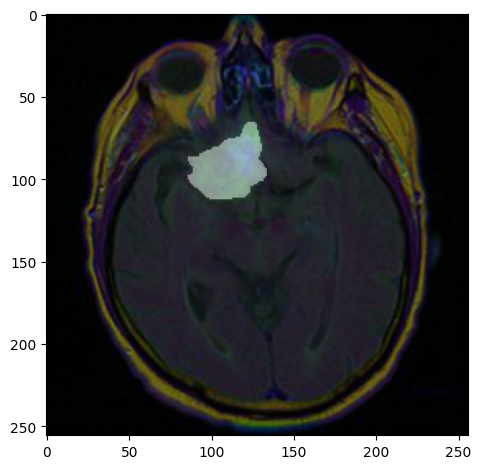

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])


plt.imshow(img)
plt.imshow(mask[:, :], alpha=0.4)
plt.tight_layout()
plt.show()

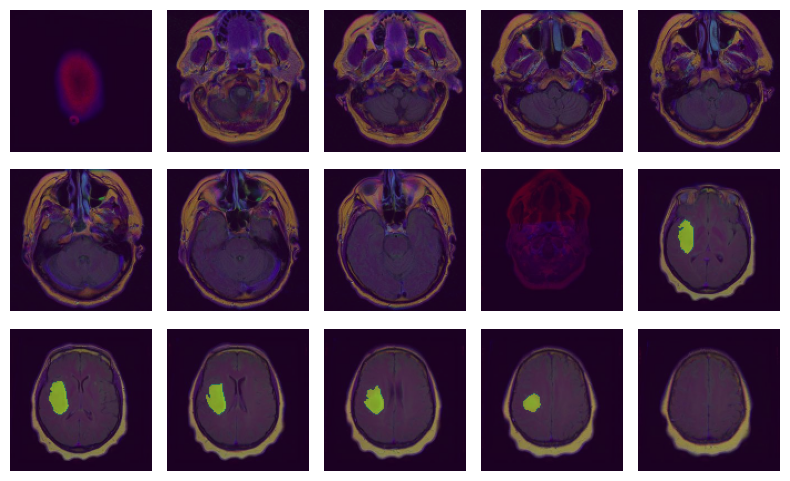

In [ ]:
images = []
masks = []
for image, mask in train_ds.skip(15).take(15):
    images.append(image.numpy().squeeze())
    masks.append(mask.numpy().squeeze())

# Criar o subplot
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(8, 5))

# Plotar cada exemplo
for i, ax in enumerate(axes.flat):
    # Obter a imagem e a máscara
    img = images[i]
    mask = masks[i]

    # Plotar a imagem com a máscara em cima
    ax.imshow(img)
    ax.imshow(mask, alpha=0.4)

    # Desabilitar os eixos
    ax.axis('off')

plt.tight_layout()
plt.show()

# <font color ="#00b8ff"> Segmentação de imagem </font>

## <font color ="#00b8ff"> 5 - U-Net </font>


U-Net, nomeado por sua forma em "U", foi originalmente criado em 2015 para detecção de tumores, mas nos anos seguintes tornou-se uma escolha muito popular para outras tarefas de segmentação semântica.

<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%203/Image%20Segmentation%20Unet/images/unet.png"/>

<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

A arquitetura da rede U-Net possui um caminho de contração (Encoder) que utiliza convoluções e max pooling para reduzir a altura e a largura da imagem, enquanto aumenta o número de canais de recursos. Em seguida, há uma etapa de corte e uma conexão de salto para o caminho de expansão (Decoder), que faz o upsampling da imagem de volta para seu tamanho original, diminuindo gradualmente o número de canais. O bloco de mapeamento de recursos finais usa uma convolução 1x1 para mapear cada vetor de recursos para o número desejado de classes. A rede possui um total de 23 camadas convolucionais e é possível reduzir as dimensões dos canais para ter uma camada por classe.

### 5.1 - Encoder (Downsampling Block)

<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%203/Image%20Segmentation%20Unet/images/encoder.png">
<caption><center> <u><b>Figura 3</u></b>: The U-Net Encoder up close <br> </center></caption>

O encoder é uma pilha de vários conv_blocks:

Cada `conv_block()` é composto por 2 camadas **Conv2D** com ativações ReLU. Aplicaremos **Dropout**, e **MaxPooling2D** a alguns conv_blocks, como verificaremos nas seções seguintes, especificamente nos dois últimos blocos do downsampling.

A função retornará dois tensores:
- `next_layer`: Que irá para o próximo bloco.
- `skip_connection`: Que irá para o bloco de decodificação correspondente.

**Nota**: Se `max_pooling=True`, o `next_layer`  será a saída da camada MaxPooling2D, mas a `skip_connection` será a saída da camada aplicada anteriormente (Conv2D ou Dropout, dependendo do caso). Caso contrário, ambos os resultados serão idênticos.

<a name='ex-1'></a>
### Exercício 1 - conv_block

Implemente `conv_block(...)`. Aqui estão as instruções para cada etapa no `conv_block`, ou bloco de contração:

* Adicione 2 camadas **Conv2D** com `n_filters` filtros e `kernel_size` definido como 3, `kernel_initializer` definido como ['he_normal'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), `padding` definido como 'same' e ativação 'relu'.
* Se `dropout_prob` > 0, então adicione uma camada Dropout com parâmetro `dropout_prob`
* Se `max_pooling` for definido como True, adicione uma camada MaxPooling2D com tamanho de pool 2x2.

In [ ]:
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Bloco de downsampling convolucional

    Argumentos:
      inputs -- Tensor de entrada
      n_filters -- Número de filtros para as camadas convolucionais
      dropout_prob -- Probabilidade de dropout
      max_pooling -- Utilizar MaxPooling2D para reduzir as dimensões espaciais do volume de saída
    Retorna:
      next_layer, skip_connection -- Saída da próxima camada e conexão de desvio (skip connection)
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    conv = BatchNormalization(axis=3)(conv)
    conv = Activation("relu")(conv)
    ### END CODE HERE

    # se dropout_prob > 0 adicione uma camada Dropout, com a variável dropout_prob como parâmetro
    if dropout_prob > 0:
      ### START CODE HERE
      conv = Dropout(dropout_prob)(conv)
      ### END CODE HERE


    # se max_pooling for definido como True, adicione uma camada MaxPooling2D com tamanho de pool 2x2.

    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D((2,2))(conv)
        ### END CODE HERE

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

<a name='3-3'></a>
### 5.2 - Decoder (Upsampling Block)

O decodificador, ou bloco de upsampling, aumenta as características de volta para o tamanho original da imagem. Em cada nível de upsampling, você pegará a saída do bloco de codificação correspondente e concatenará antes de alimentar para o próximo bloco de decodificação.

<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%203/Image%20Segmentation%20Unet/images/decoder.png">
<caption><center> <u><b>Figura 4</u></b>: The U-Net Decoder up close <br> </center></caption>

Existem dois novos componentes no decodificador: up e merge. Estes são a convolução transposta e as conexões de salto. Além disso, existem mais duas camadas convolucionais definidas com os mesmos parâmetros que no codificador.

Aqui você encontrará a camada `Conv2DTranspose`, que realiza o inverso da camada `Conv2D`. Você pode ler mais sobre isso [aqui.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)

<a name='ex-2'></a>
### Exercício 2 - upsampling_block

Implemente `upsampling_block(...)`.

Para a função `upsampling_block`:

* Recebe os argumentos `expansive_input` (que é o tensor de entrada da camada anterior) e contractive_input (o tensor de entrada da camada de salto anterior)
* O número de filtros aqui é o mesmo que na camada de downsampling que você completou anteriormente.
* Sua camada `Conv2DTranspose` terá `n_filters` com formato (3,3) e um passo de (2,2), com padding definido como `same`. É aplicado em `expansive_input`, ou seja, o tensor de entrada da camada anterior.


Nesse bloco é onde você concatenará as saídas dos blocos do codificador, criando as conexões de salto.

* Concatene a saída da camada Conv2DTranspose com a entrada contractive, com um axis de 3. Em geral, você pode concatenar os tensores na ordem que preferir. Mas para o avaliador, é importante que você use `[up, contractive_input]`

Para o componente final, defina os parâmetros de duas camadas Conv2D com os mesmos valores que você definiu para as duas camadas Conv2D no codificador (ativação ReLU, inicialização He normal, preenchimento `same`).

In [ ]:
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Bloco de aumento de convolução

    Argumentos:
        expansive_input - tensor de entrada da camada anterior
        contractive_input - tensor de entrada do salto anterior
        n_filters - número de filtros para as camadas convolucionais
    Retorna:
        conv - saída do tensor
    """

    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)

    # Concatene a saída anterior com o contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    conv = BatchNormalization(axis=3)(conv)
    conv = Activation("relu")(conv)
    ### END CODE HERE

    return conv

<a name='3-4'></a>
### 5.3 - Construir o modelo

Aqui é onde você vai juntar tudo, conectando o encoder, o bottleneck e o decoder! Você precisará especificar o número de canais de saída, que neste conjunto de dados específico seria 2. Isso porque existem 2 possíveis rótulos para cada pixel neste dataset de tumores cerebrais.

<a name='ex-3'></a>
### Exercício 3 - unet_model

Para a função `unet_model`, especifique o formato de entrada, número de filtros e número de classes (2 neste caso).

Para a primeira metade do modelo:

* Comece com um bloco convolucional que recebe as entradas do modelo e o número de filtros
* Em seguida, encadeie o primeiro elemento de saída de cada bloco na entrada do próximo bloco convolucional
* Em seguida, dobre o número de filtros em cada etapa
* Começando com `conv_block4`, adicione um `dropout_prob` de 0,3
* Para o último conv_block, defina `dropout_prob` para 0,3 novamente e desative o max pooling

Para a segunda metade:

* Use cblock5 como expansive_input e cblock4 como contractive_input, com `n_filters` * 8. Esta é sua camada bottleneck.
* Encadeie a saída do bloco anterior como expansive_input e a saída do bloco contrativo correspondente.
* Note que você deve usar o segundo elemento do bloco contrativo antes da camada de max pooling.
* Em cada etapa, use metade do número de filtros do bloco anterior
`conv9` é uma camada Conv2D com ativação ReLU, inicializador He normal, padding `same`
* Finalmente, `conv10` é uma Conv2D que leva o número de classes como filtro, um tamanho de kernel de 1 e padding "same". A saída de `conv10` é a saída do seu modelo.


In [ ]:
# GRADED FUNCTION: unet_model
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1):
    """
    Modelo U-Net

    Argumentos:
        input_size -- Tamanho da entrada
        n_filters -- Número de filtros para as camadas convolucionais
        n_classes -- Número de classes de saída
    Retorna:
        modelo -- tf.keras.Model
    """

    inputs = Input(input_size)

    # Caminho de contração (encoding)
    # Adicione um conv_block com as entradas do modelo unet_ e n_filters

    ### START CODE HERE

    cblock1 = conv_block(inputs = inputs,n_filters =  n_filters*1)

    # Encadeie o primeiro elemento da saída de cada bloco para ser a entrada do próximo conv_block.
    # Dobre o número de filtros em cada novo passo.

    cblock2 = conv_block(inputs = cblock1[0], n_filters = n_filters * 2)
    cblock3 = conv_block(inputs = cblock2[0], n_filters = n_filters * 4)
    cblock4 = conv_block(inputs = cblock3[0], n_filters = n_filters * 8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer

    # Inclua um dropout_prob de 0.3 para essa camada, e desative a camada max_pooling

    cblock5 = conv_block(inputs = cblock4[0], n_filters = n_filters * 16, dropout_prob=0.3, max_pooling=False)

    ### END CODE HERE

    # Caminho de expansão (decoding)

    # Adicione o primeiro bloco de upsampling.
    # Use cblock5[0] como expansive_input e cblock4[1] como contractive_input, com n_filters * 8

    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)

    # Encadeie a saída do bloco anterior como entrada expansiva e a saída correspondente do bloco contrativo.
    # Observe que você deve usar o segundo elemento do bloco contrativo, ou seja, antes da camada de maxpooling.
    # Em cada etapa, use metade do número de filtros do bloco anterior.

    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters*1)

    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                  # coloque 'kernel_initializer' como sendo o mesmo utilizado nos exercicios.
                 kernel_initializer='he_normal')(ublock9)

    # Adicione uma camada Conv2D com n_classes filtros, kernel size de 1 e um padding 'same'

    ### START CODE HERE

    conv10 = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(conv9)


    ### END CODE HERE

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    return model

<a name='5.4'></a>
### 5.4 - Dimensões do Modelo

In [ ]:
img_height = 128
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

<a name='5-5'></a>
### 5.5 - Loss Function

... usar entropia cruzada categórica esparsa ou normal ?


In [ ]:
unet.compile(Adam(learning_rate= 0.0001), loss= 'binary_crossentropy', metrics= ['accuracy'])

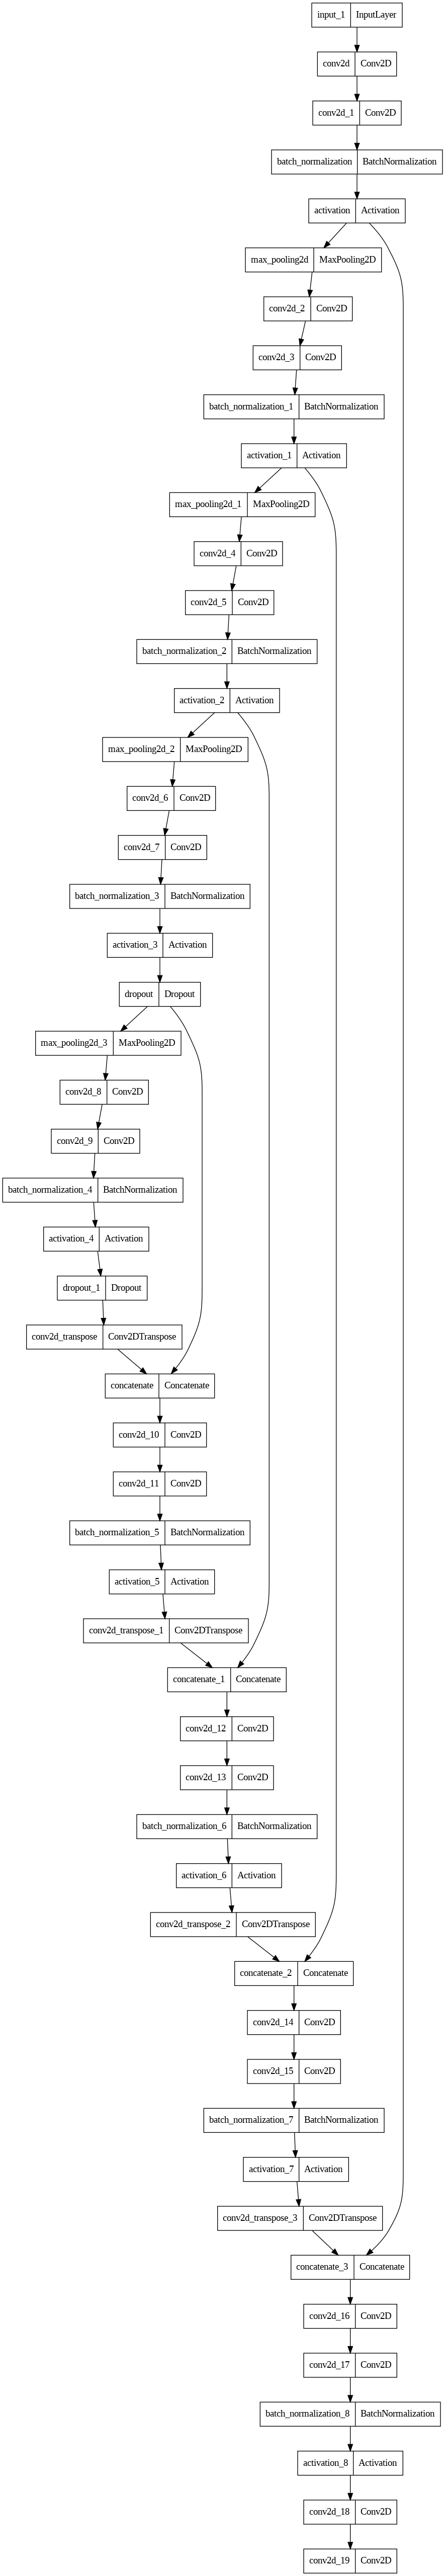

In [ ]:
plot_model(unet,to_file='unet.png')

<a name='5-6'></a>
### 5.6 - Dataset Handling

Abaixo, defina uma função que permita exibir tanto uma imagem de entrada quanto sua verdadeira máscara: a máscara real. A máscara real é o que a saída do modelo treinado está tentando se aproximar o máximo possível.

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))

    plt.show()

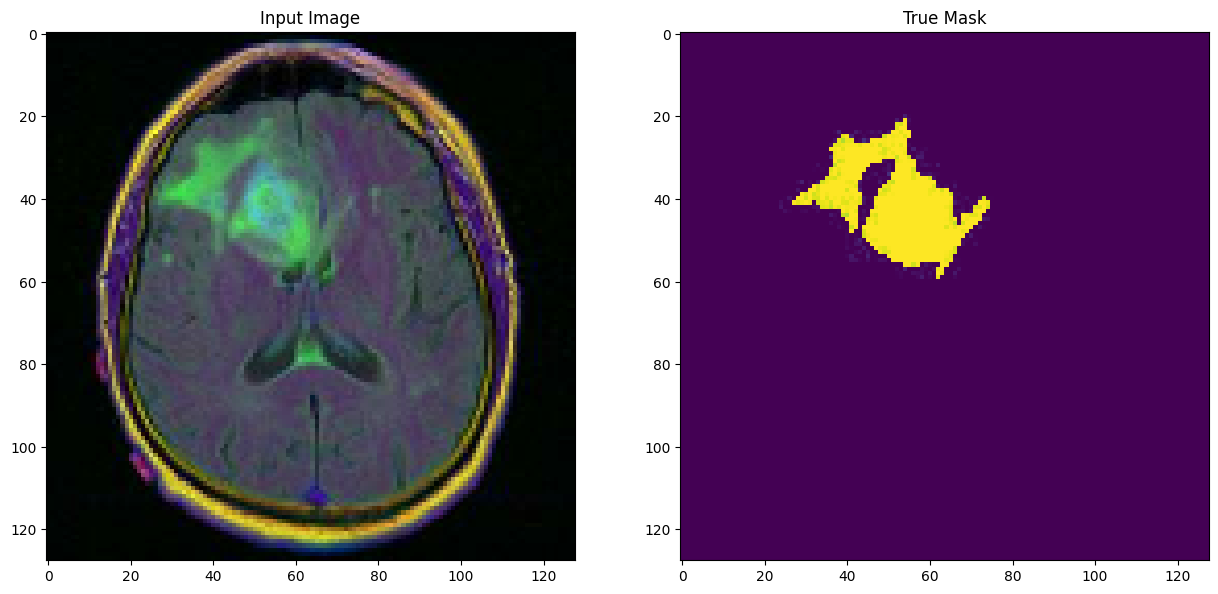

In [ ]:
for image, mask in train_ds.take(6):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

## 6 - Treinar o Modelo

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 1000
BATCH_SIZE = 64
train_dataset = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = val_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
filepath = "/content/drive/MyDrive/VisãoComputacional/unet_model4.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
print(train_ds.element_spec)
model_history = unet.fit(train_dataset,
                         epochs=EPOCHS,
                         validation_data=validation_dataset,
                         callbacks=[checkpoint])

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))
Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.9345 
Epoch 1: val_accuracy improved from -inf to 0.98315, saving model to /content/drive/MyDrive/VisãoComputacional/unet_model4.h5
41/41 [==============================] - 1710s 41s/step - loss: 0.2850 - accuracy: 0.9345 - val_loss: 0.5196 - val_accuracy: 0.9831
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9884 
Epoch 2: val_accuracy improved from 0.98315 to 0.98318, saving model to /content/drive/MyDrive/VisãoComputacional/unet_model4.h5
41/41 [==============================] - 1603s 39s/step - loss: 0.0789 - accuracy: 0.9884 - val_loss: 0.2948 - val_accuracy: 0.9832
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9900 
Epoch 3: val_accuracy improved from 0.98318 to 0.98432, saving model to

In [ ]:
#unet.load_weights('/content/drive/MyDrive/VisãoComputacional/unet_model3.h5')#

In [ ]:
unet2 = tf.keras.models.load_model('/content/drive/MyDrive/VisãoComputacional/unet_model3.h5')

### 6.1 - Crie Máscaras Previstas

Agora, defina uma função que usa `tf.argmax` no eixo do número de classes para retornar o índice com o maior valor e mescla a previsão em uma única imagem:

In [ ]:
def create_mask(pred_mask, threshold=0.4):
    pred_mask = tf.cast(pred_mask > threshold, dtype=tf.float32)
    pred_mask = pred_mask[0]
    return pred_mask

### 6.2 - Plotar Acurácia do Modelo

Vamos ver como o modelo se saiu!

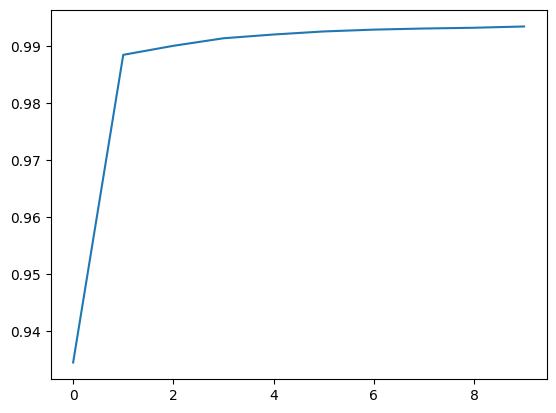

In [ ]:
plt.plot(model_history.history["accuracy"])

### 6.3 - Mostrar predições

Em seguida, verifique as suas máscaras previstas em relação à máscara real e à imagem de entrada original:

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet.predict(image)
      pred_mask = create_mask(pred_mask)


      display([image[0], mask[0], pred_mask])
  else:
    display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
test_dataset = test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2/2 [==============================] - 10s 4s/step


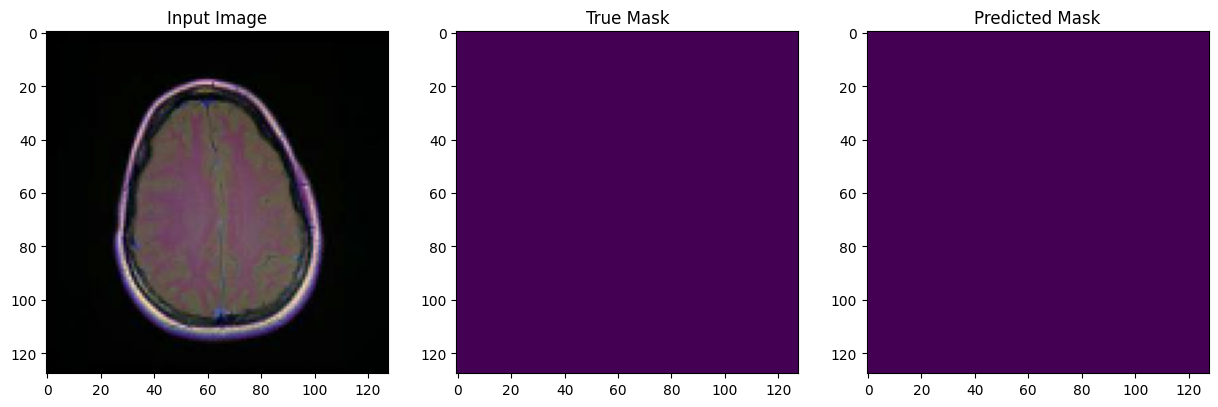

2/2 [==============================] - 10s 4s/step


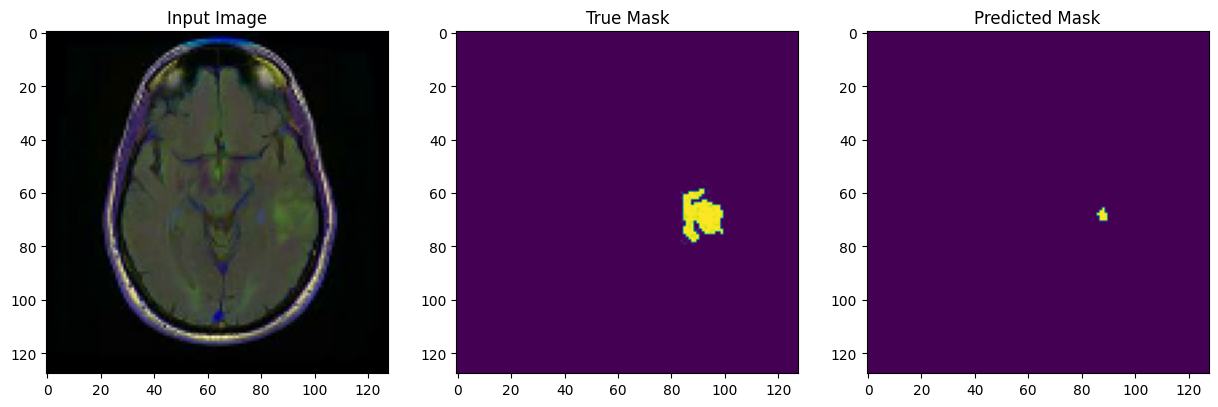

2/2 [==============================] - 10s 6s/step


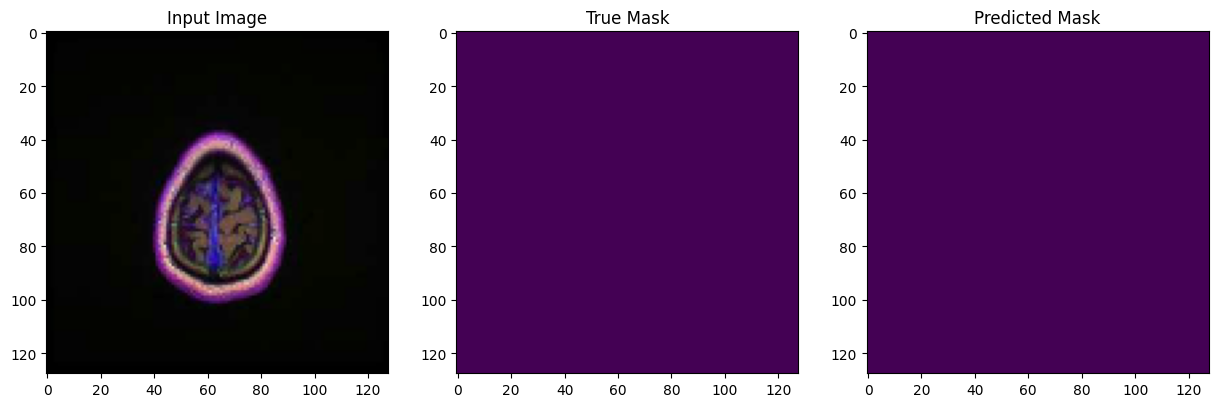

2/2 [==============================] - 8s 4s/step


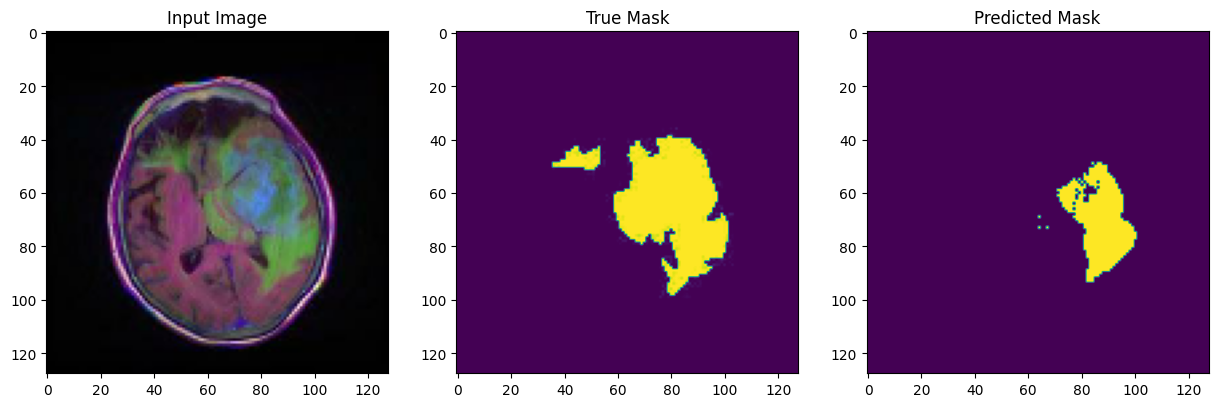

2/2 [==============================] - 10s 4s/step


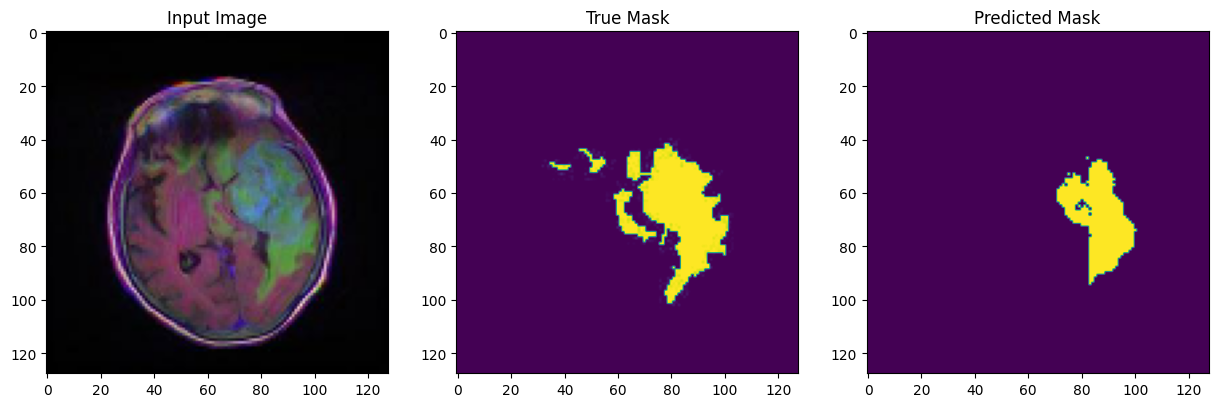

1/1 [==============================] - 1s 1s/step


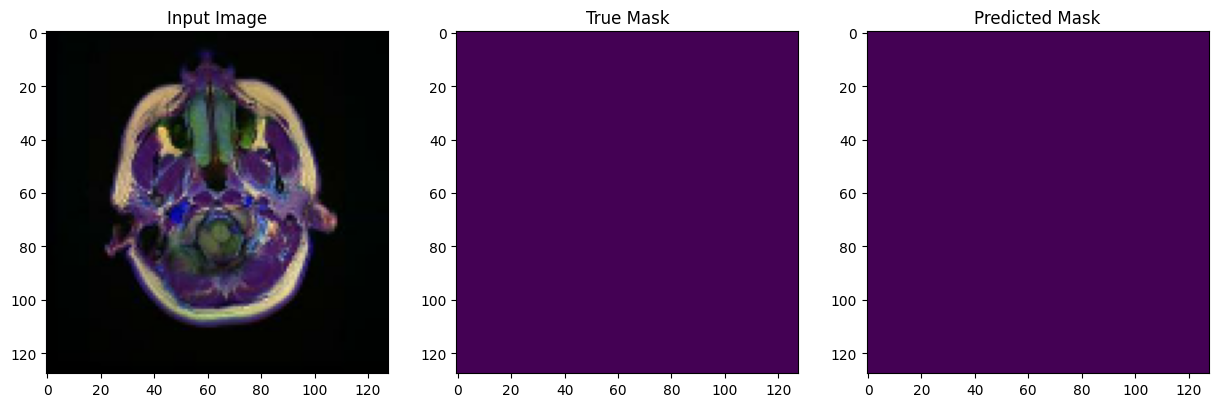

In [ ]:
show_predictions(test_dataset, 6)

# <font color ="#00b8ff"> Conclusão </font>
**O que você deve lembrar:**

* A segmentação semântica de imagens prevê uma label para cada pixel em uma imagem
* U-Net utiliza um número igual de blocos convolucionais e convoluções transpostas para downsampling e upsampling
* As conexões "skip" são usadas para evitar a perda de informações de pixels de borda e overfitting na U-Net.

In [ ]:
model_path = "/content/drive/MyDrive/VisãoComputacional/unet_sucess_ten_epochs.h5"
unet.save(model_path)


# Separando as imagens das máscaras

Código usado para separar as imagens das mascaras que veio no dataset do kaggle

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!unzip /content/drive/MyDrive/VisãoComputacional/BrainSegmentation.zip -d /content/

In [ ]:
#root_dir = "/content/kaggle_3m"

In [ ]:
# images_folder = "/content/TumorImgs"
# masks_folder = "/content/MaskImgs"

In [ ]:
# file_pattern = re.compile(r"^TCGA_\w+_\d+_\d+_\d+\.tif$")
# mask_pattern = re.compile(r"^(TCGA_\w+_\d+_\d+_\d+)\.tif$")
# count = 0
# # Percorrer todas as pastas e arquivos
# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         # Verificar se o arquivo é um arquivo TIFF
#         if file_pattern.match(file):
#             # Construir o caminho completo para o arquivo e sua correspondente máscara
#             file_path = os.path.join(subdir, file)
#             mask_filename = mask_pattern.sub(r"\1_mask.tif", file)
#             mask_path = os.path.join(subdir, mask_filename)

#             # Verificar se a máscara existe
#             if os.path.isfile(mask_path):
#                 # Construir os caminhos completos para as pastas de imagens e máscaras
#                 images_path = os.path.join(subdir, images_folder)
#                 masks_path = os.path.join(subdir, masks_folder)
#                 # Criar as pastas de imagens e máscaras, se elas ainda não existirem
#                 os.makedirs(images_path, exist_ok=True)
#                 os.makedirs(masks_path, exist_ok=True)

#                 # Copiar o arquivo para a pasta de imagens e sua correspondente máscara para a pasta de máscaras
#                 shutil.copy(file_path, images_path)
#                 shutil.copy(mask_path, masks_path)
#                 count+=1

# print("Salvos " + str(count) + " Arquivos")

In [ ]:
# import zipfile
# from google.colab import files

# def download_path(path):
#   zip_filename = path + ".zip"
#   zip_file = zipfile.ZipFile(zip_filename, mode='w')

#   # Iterate over all the files in the directory and add them to the zip file
#   for file_name in os.listdir(path):
#       file_path = os.path.join(path, file_name)
#       zip_file.write(file_path)

#   zip_file.close()
#   # Faça o download do arquivo zip
#   files.download(zip_filename)


# download_path("TumorImgs")
# download_path("MaskImgs")